In [13]:
# Third-party imports
from math import ceil
import os
import vrplib

# Own imports
from src.new.display import DisplayModel
from src.new.ants import FreeAnt
from src.new.acs import ACS
from src.new.helpers import create_directory, download_instance, get_distances_matrix
from src.new.heuristics import HeuristicModel
from src.new.metaheuristics import GeneralVNS
from src.new.models import VRPModel

In [14]:
# Parameters to handle the algorithm
%matplotlib inline

ALPHA = 1  # 0.75, 1, 1.05, 1.1, 1.25, 1.5, 1.75, 2
ANTS_NUM_RELATION = 1  # 1, 2
BETA = 5  # 2, 2.5, 3,  3.5
CANDIDATE_NODES_TYPE = None # None, 'best', 'random'
GAMMA = 3  # 1, 1.5 2
HEURISTICS_TO_USE = ['distance', 'saving'] # ['distance'], ['saving'], ['distance', 'saving']
ITERATION_LOCAL_SEARCH_MODEL = None  # None, GeneralVNS
MAX_ITERATIONS = 500
MIN_ITERATIONS = 200
PHEROMONES_ONLINE_UPDATE = True  # True, False
PHEROMONES_UPDATE_TYPE = 'g_best' # 'all_ants', 'it_best', 'g_best', 'pseudo_g_best'
PROBABILITIES_MATRIX_TYPE = 'normalized'  # 'classic', 'normalized'
Q_0 = 0.8 # 0.8, 0.85, 0.9, 0.95
RHO = 0.1  # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
TARE_PERCENTAGE = 0.15

# Instance to solve
LIB = 'CMT'
INSTANCE = 'CMT2'

# Parameters to handle the display
PLOT_INSTANCE = False
PLOT_SOLUTION = True

In [15]:
# Initialize everything
project_path = os.getcwd()
instance_file_exists = os.path.isfile(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')

if not instance_file_exists:
    create_directory(f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}/')
    success = download_instance(
        INSTANCE, f'{project_path}/instances/CVRPLIB/{LIB}/')

    if not success:
        raise Exception('Error downloading the instance')


instance = vrplib.read_instance(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')
solution = vrplib.read_solution(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.sol')

demands = instance['demand']
nodes = [node for node in range(len(demands))]
clients = nodes[1:]
max_capacity = instance['capacity']
matrix_coords = instance['node_coord']
k_optimal = ceil(sum(demands)/max_capacity)

optimal_cost = None
if solution['cost']:
    optimal_cost = solution['cost']
else:
    optimal_cost = float(instance['comment']) if instance['comment'] else None

errors = VRPModel.validate_instance(nodes, demands, max_capacity)
if errors:
    raise Exception(errors)

iterations = max(round(len(nodes), -2), MIN_ITERATIONS)
matrix_distances = get_distances_matrix(nodes, matrix_coords)

parameters_heuristics = {
    'demands': demands,
    'importance_distances': BETA,
    'importance_savings': GAMMA,
    'matrix_coords': matrix_coords,
    'nodes': nodes,
}

heuristics = HeuristicModel(**parameters_heuristics)
matrix_heuristics = heuristics.get_heuristic_matrix(HEURISTICS_TO_USE)

parameters_ants = {
    'alpha': ALPHA,
    'ants_num': ceil(len(clients) / ANTS_NUM_RELATION),
    'demands': demands,
    'ipynb': True,
    'k_optimal': k_optimal,
    'matrix_costs': matrix_distances,
    'matrix_heuristics': matrix_heuristics,
    'max_capacity': max_capacity,
    'max_iterations': min(iterations, MAX_ITERATIONS),
    'model_ant': FreeAnt,
    'model_ls_it': ITERATION_LOCAL_SEARCH_MODEL,
    'model_problem': VRPModel,
    'nodes': nodes,
    'pheromones_online_update': PHEROMONES_ONLINE_UPDATE,
    'q0': Q_0,
    'rho': RHO,
    'tare': max_capacity * TARE_PERCENTAGE,
    'type_candidate_nodes': CANDIDATE_NODES_TYPE,
    'type_pheromones_update': PHEROMONES_UPDATE_TYPE,
    'type_probabilities_matrix': PROBABILITIES_MATRIX_TYPE,
}

In [16]:
# Render the problem

if PLOT_INSTANCE:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_problem(nodes, demands, matrix_coords, instance_name)

In [17]:
# Run the algorithm

acs = ACS(**parameters_ants)
results = acs.solve()


PARAMETERS
----------------------------------------
AS:
	alpha: 1
	ants_num: 75
	beta: 1
	demands: 76
	evaporation_rate: 0.8
	iterations_local_search: no
	k_optimal: 10
	lst_clusters: no
	max_capacity: 140
	max_iterations: 200
	min_demand: 0, max_demand: 37, mean: 17.94736842105263
	model_ant: Free Ant
	nodes: 75
	rho: 0.1
	t_max: 1.00000000000000000000000000000000000000000000000000
	t_min: 0.00000000000000000000000000000000000000000000000000
	tare: 21.0
	type_candidate_nodes: None
	type_pheromones_update: g_best
	type_probabilities_matrix: normalized
----------------------------------------
ACS:
	epsilon: 0.0013333333333333335
	pheromones_local_update: yes
	q0: 1
	t_zero: 0.00001102138211553998146366353111380576024203037377




Global Best -> 1209.76963:  20%|█▉        | 39/200 [00:04<00:18,  8.81it/s]


KeyboardInterrupt: 

Optimal cost: 835.262
Best cost: 967.9117740993447
Difference %: 15.88


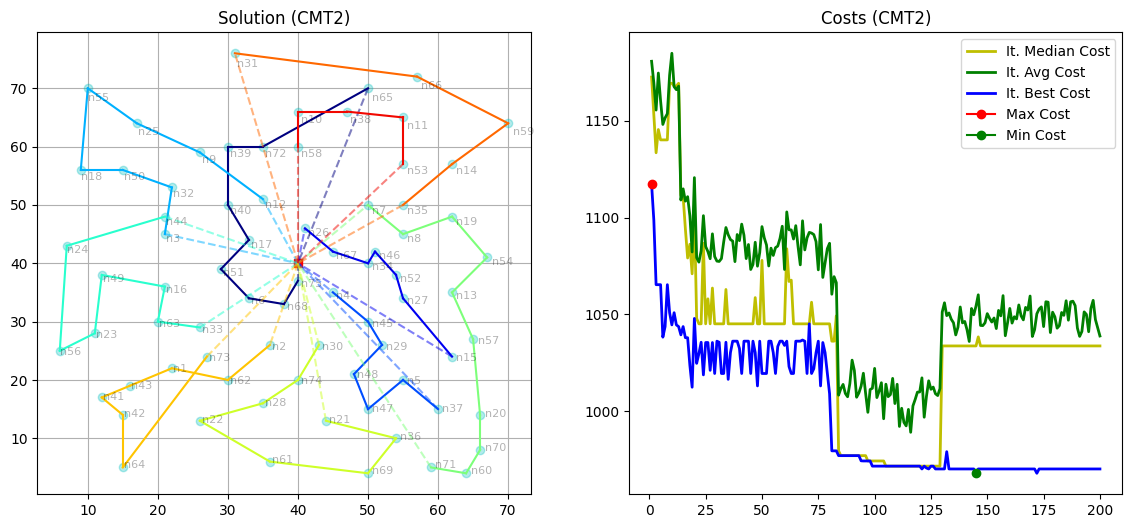

In [ ]:
if optimal_cost:
    print(f'Optimal cost: {optimal_cost}')
    print(f'Best cost: {results["global_best_solution"]["cost"]}')
    print(f'Difference %: {round((results["global_best_solution"]["cost"] - optimal_cost) / optimal_cost * 100, 2)}')
    
if PLOT_SOLUTION:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_solution(results['global_best_solution'], matrix_coords, instance_name, results['best_solutions'], results['iterations_mean_costs'], results['iterations_median_costs'])